In [1]:
%%html
<link href='https://fonts.googleapis.com/css?family=Roboto' rel='stylesheet'>
<style>
body {
    font-family: 'Roboto', 'Helvetica', sans-serif; 
    font-size: 16px;
}
</style>

<div style="background-color: #2b3237; padding-top: 20px;
  padding-right: 30px;
  padding-bottom: 10px;
  padding-left: 30px; width: 100%; display: flex">

<div style="background-color: #2b3237; padding-top: 20px;
  padding-right: 30px;
  padding-bottom: 20px;
  padding-left: 0px; width: 100%">

<font color=#ffffff size=6> <strong>Regional Voting Preferences in the 2016 Philippine Elections</strong> </font>
</div>
</div>

<div style="background-color: #e9e6e3; padding-top: 20px;
  padding-right: 15px;
  padding-bottom: 20px;
  padding-left: 30px">
<font color=#2b3237> <strong> George Allan Esleta (gesleta@aim.edu) </strong></font>
</div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import geopandas as gpd
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">TASK </span></div>

1.	Create a denormalized table replacing `precinct_code` in the `results_*.csv` files with the columns: region, province, municipality, and barangay. 
2.	Create an interesting data visualization using this dataset.

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">DATA </span></div>

There are three (3) data sources, namely:

- `ref_table_precinct_locations_PSGC.csv` – lookup table for precincts
- `results_president.csv` – precinct-level election results for the 2016 presidential race
- `results_vice-president.csv` – precinct-level election results for the 2016 vice presidential race

## 1. Precinct Data

Workflow:
1. Load precinct data
2. Check data columns
3. Check for missing/ null values

### a. Load precint data

In [ ]:
df_precinct = pd.read_csv('Datasets/ref_table_precinct_locations_PSGC.csv') 

In [ ]:
df_precinct.head()

### b. Check data columns

In [ ]:
df_precinct.info()

There are **90,642** precinct entries in the data. The `precinct` lookup table has the following columns:

In [ ]:
df_precinct.shape

| Column | Data type | Description |
|---|---|---|
| `precinct_code`  | int | Unique identification number of the precinct |
|`region           ` | categorical | Administrative region where the precinct is located |
|`province         ` |object | Province where the precinct is located |
|`municipality     ` |object | Municipality/City where the precinct is located |
|`barangay         ` |object | Barangay where the precinct is located |
|`registered_voters` |int64  | Number of registered voters in the precinct |
|`ballots_cast     ` |int64  | Number of votes cast in the precinct |
|`PSGC_CM          ` |object | Philippine Standard Geographic Code (PSGC) for the city/municipality |
|`is_city          ` |boolean| True if the LGU is a city |
|`income_class     ` |object | Income class of the city/municipality |
|`population       ` |float64| Population of the city/municipality |
|`land_area        ` |float64| Land area of the city/municipality |
|`province_CM      ` |object | Name of the province in the PSGC database |
|`municipality_CM  ` |object | Name of the municipality/city in the PSGC database |

### c. Check for null values

The precinct data has no missing/ null values for the `precinct_code`, `region`, `province`, `municipality`, and `barangay` columns.

In [ ]:
df_precinct.isnull().sum()

### d. Checking for uniqueness and duplicates

The `precinct_code` column has no duplicate values.

In [ ]:
df_precinct.nunique(axis=0, dropna=True)

### e. Check unique values of Region

There are **nineteen (19)** unique regions in the precinct lookup data:

In [ ]:
print(f"There are {df_precinct['region'].nunique()} unique regions.")

In [ ]:
print(sorted(df_precinct['region'].unique()))

Note that ***Overseas Absentee Voters (OAV)*** are considered as a separate administrative region. Also, **Negros Island Region (NIR)**, which was dissolved in 2017, is still included in the database.

### f. Check unique values of Province

There are two (2) province-related columns: `province` and `province_CM`. Checking if there are discrepancies between the two columns:

In [ ]:
df_precinct[df_precinct['province_CM'] != df_precinct['province']].shape

The two columns have identical values for all records and therefore can be used interchangeably. For simplicity, the `province_CM` column will be used, as this is the official name of the province in the PSA records.

There are **ninety (90)** unique `province` values:

In [ ]:
print(sorted(df_precinct['province_CM'].unique()))

### f. Check unique values of Municipality

There are two (2) municipality-related columns: `municipality` and `municipality_CM`. Checking if there are discrepancies between the two columns:

In [ ]:
df_precinct[df_precinct['municipality_CM'] != df_precinct['municipality']].shape

For the National Capital Region, the `municipality` column contains district names instead of the city name. 

In [ ]:
df_precinct[df_precinct['municipality_CM'] != df_precinct['municipality']].head()

The `municipality_CM` column will be used moving forward.

### g. Drop `province` and `municipality` columns

In [ ]:
df_precinct.drop(['Unnamed: 0', 'province', 'municipality'], axis=1, inplace=True)

### i. rename columns

In [ ]:
df_precinct.rename(columns={'province_CM': 'province', 'municipality_CM': 'municipality'}, inplace=True)

In [ ]:
df_precinct.columns

### Create mapping of region with provinces

We check the accuracy of the `region` and `province` fields in the precinct database by creating a region-province mapping from the data. The data was grouped by region, and the unique province values for each region was obtained. The resulting mapping is saved in a dictionary `region_map`.

In [ ]:
region_map = dict(df_precinct[['region', 'province']].groupby('region')['province'].unique().apply(lambda x: sorted(list(x))))

In [ ]:
with open('Datasets/regions_mapping.pkl', 'wb') as f:
    pickle.dump(region_map, f)

In [42]:
with open('Datasets/regions_mapping.pkl', 'rb') as f:
    region_map = pickle.load(f)

In [ ]:
regions = list(region_map.keys())

In [ ]:
regions

In [ ]:
for region in regions:
    print(f'{region}')
    for province in region_map[region]:
        print(f'\t{province}')

In [ ]:
cols = ['precinct_code', 'region', 'province', 'municipality', 'barangay']

## 2 President Data

In [ ]:
df_president = pd.read_csv('Datasets/results_president.csv') 

In [ ]:
df_president.head()

In [ ]:
df_president.shape

In [ ]:
df_president.columns

In [ ]:
print(df_president.info())

In [ ]:
df_president.isnull().sum()

In [ ]:
df_president.nunique()

In [ ]:
print(sorted(df_president['candidate_name'].unique()))

In [ ]:
df_pres_merged = pd.merge(df_president, df_precinct[cols], on='precinct_code', how='left')

In [ ]:
df_pres_merged.shape

In [ ]:
df_pres_merged.isnull().sum()

In [ ]:
df_pres_merged.drop(['precinct_code'], axis=1, inplace=True)

In [ ]:
df_pres_merged.head()

In [ ]:
with open('Datasets/president_merged.pkl', 'wb') as f:
    pickle.dump(df_pres_merged, f)

## 2 Vice-President Data

In [ ]:
df_vp = pd.read_csv('Datasets/results_vice-president.csv') 

In [ ]:
df_vp.head()

In [ ]:
df_vp.shape

In [ ]:
print(df_vp.info())

In [ ]:
df_vp.isnull().sum()

In [ ]:
df_vp.nunique()

In [ ]:
print(sorted(df_vp['candidate_name'].unique()))

In [ ]:
df_vp_merged = pd.merge(df_vp, df_precinct[cols], on='precinct_code', how='left')

In [ ]:
df_vp_merged.head()

In [ ]:
df_vp_merged.isnull().sum()

In [ ]:
df_vp_merged.drop(['precinct_code'], axis=1, inplace=True)

In [ ]:
df_vp_merged

In [ ]:
with open('Datasets/vice-president_merged.pkl', 'wb') as f:
    pickle.dump(df_vp_merged, f)

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">QUESTION </span></div>

1. Which regions/provinces do block voting; i,e, vote for the President and Vice President candidate from the same party?
2. Bailwicks per candidate

<div><span style="background-color: #2b3237; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #43a1e5; font-size: 20px; font-weight: bold">EXPLORATORY DATA ANALYSIS </span></div>

The denormalized presidential and vice-presidential election results are explored below.

In [3]:
with open('Datasets/president_merged.pkl', 'rb') as f:
    df_pres = pickle.load(f)

In [4]:
with open('Datasets/vice-president_merged.pkl', 'rb') as f:
    df_vp = pickle.load(f)

## 1. Total votes

In [5]:
df_pres['votes'].sum()

41278124

In [6]:
df_vp['votes'].sum()

39832254

## 2. Total votes per candidate

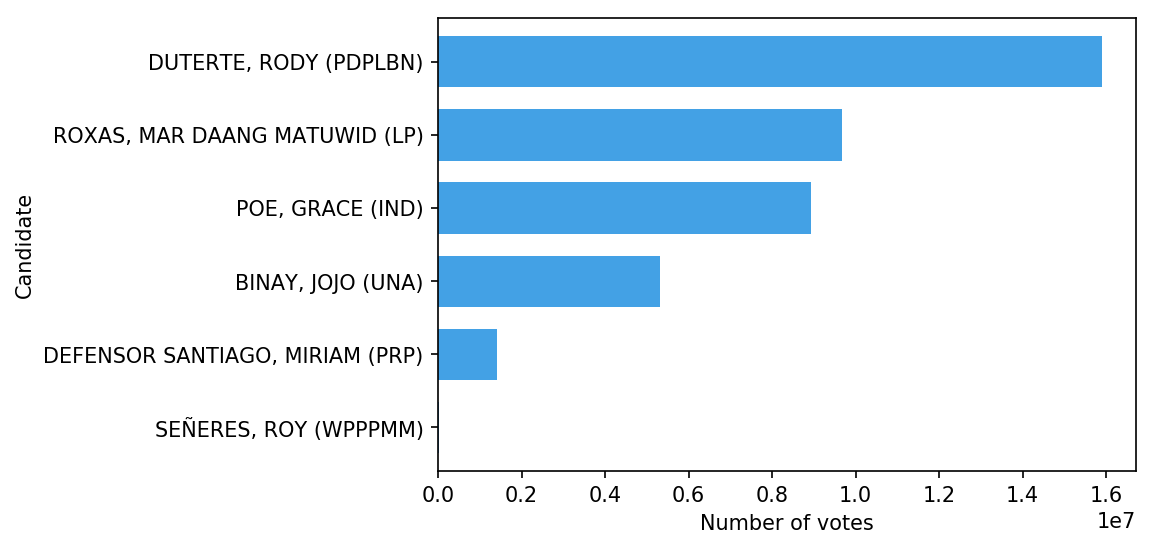

In [7]:
fig, ax = plt.subplots(dpi=150)
df_pres.groupby('candidate_name')['votes'].agg(sum).sort_values(ascending=True).plot(kind='barh', color='#43a1e5', ax=ax, width=0.7)
ax.set_ylabel('Candidate')
ax.set_xlabel('Number of votes');

#### Figure 1. Total votes obtained by each presidential candidate.

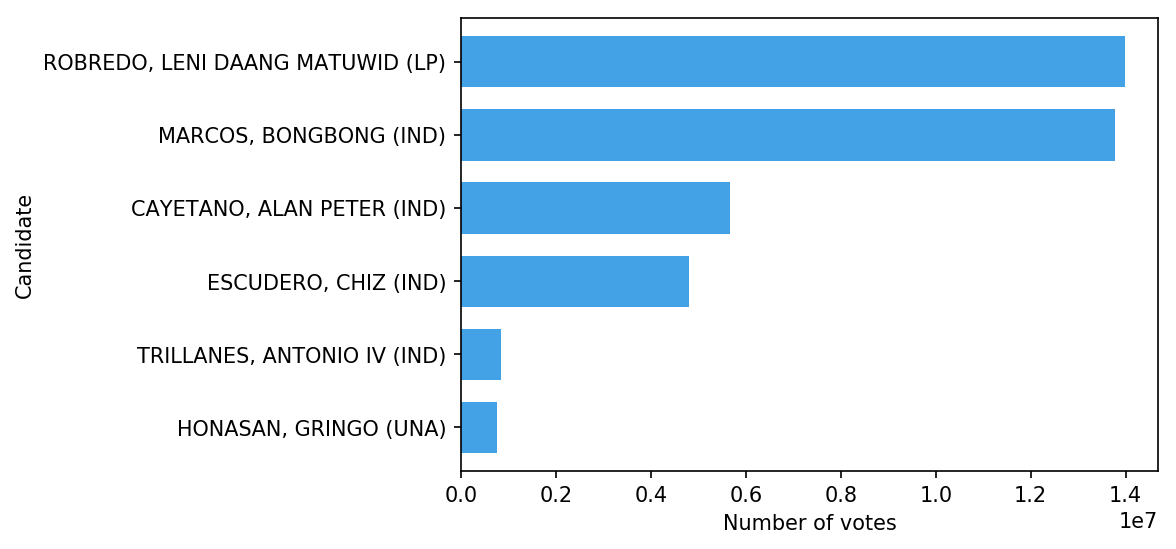

In [8]:
fig, ax = plt.subplots(dpi=150)
df_vp.groupby('candidate_name')['votes'].agg(sum).sort_values(ascending=True).plot(kind='barh', color='#43a1e5', ax=ax, width=0.7)
ax.set_ylabel('Candidate')
ax.set_xlabel('Number of votes');

#### Figure 2. Total votes obtained by each vice-presidential candidate.

## 3. Total Votes per Region

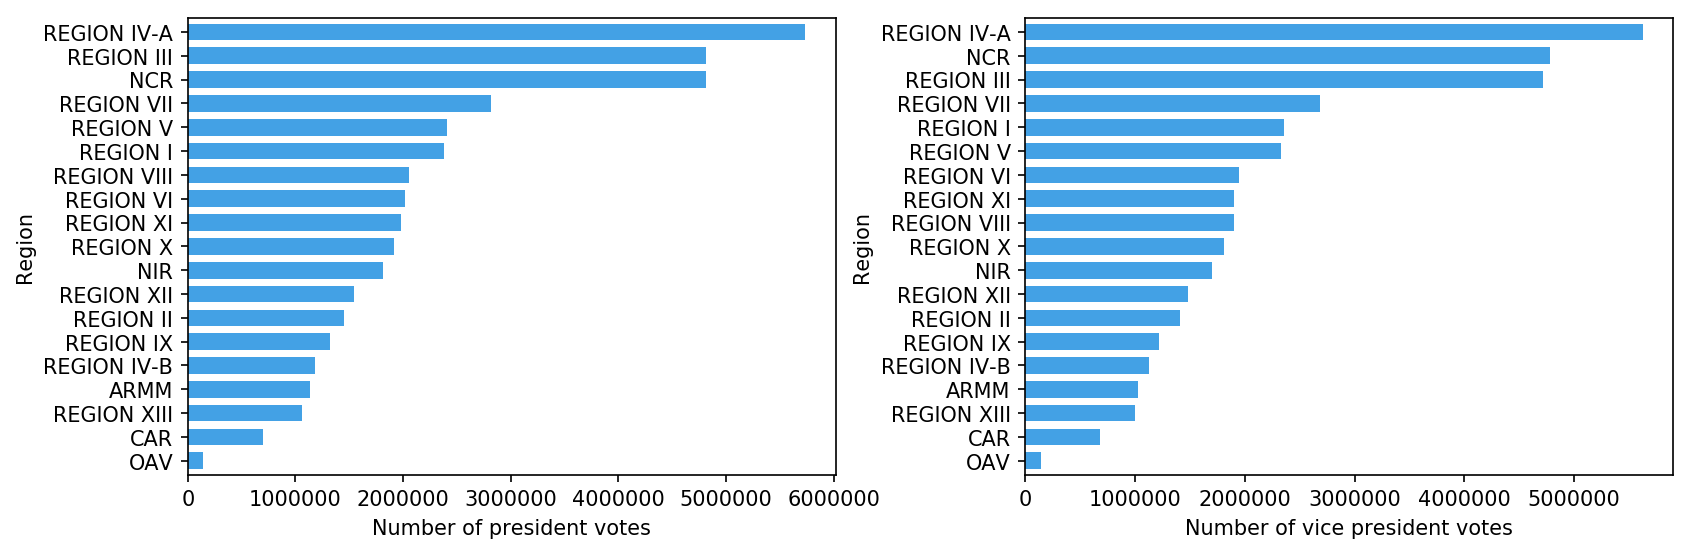

In [19]:
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(12,5))
fig.tight_layout(pad=6.0)
df_pres.groupby('region')['votes'].agg(sum).sort_values(ascending=True).plot(kind='barh', color='#43a1e5', ax=ax[0], width=0.7)
ax[0].set_ylabel('Region')
ax[0].set_xlabel('Number of president votes')
df_vp.groupby('region')['votes'].agg(sum).sort_values(ascending=True).plot(kind='barh', color='#43a1e5', ax=ax[1], width=0.7)
ax[1].set_ylabel('Region')
ax[1].set_xlabel('Number of vice president votes');

#### Figure 3. Total presidential and vice-presidential votes obtained per administrative region. CALABARZON, Central Luzon, and NCR are the regions with the largest voter population.

## 4. Total Votes per Province

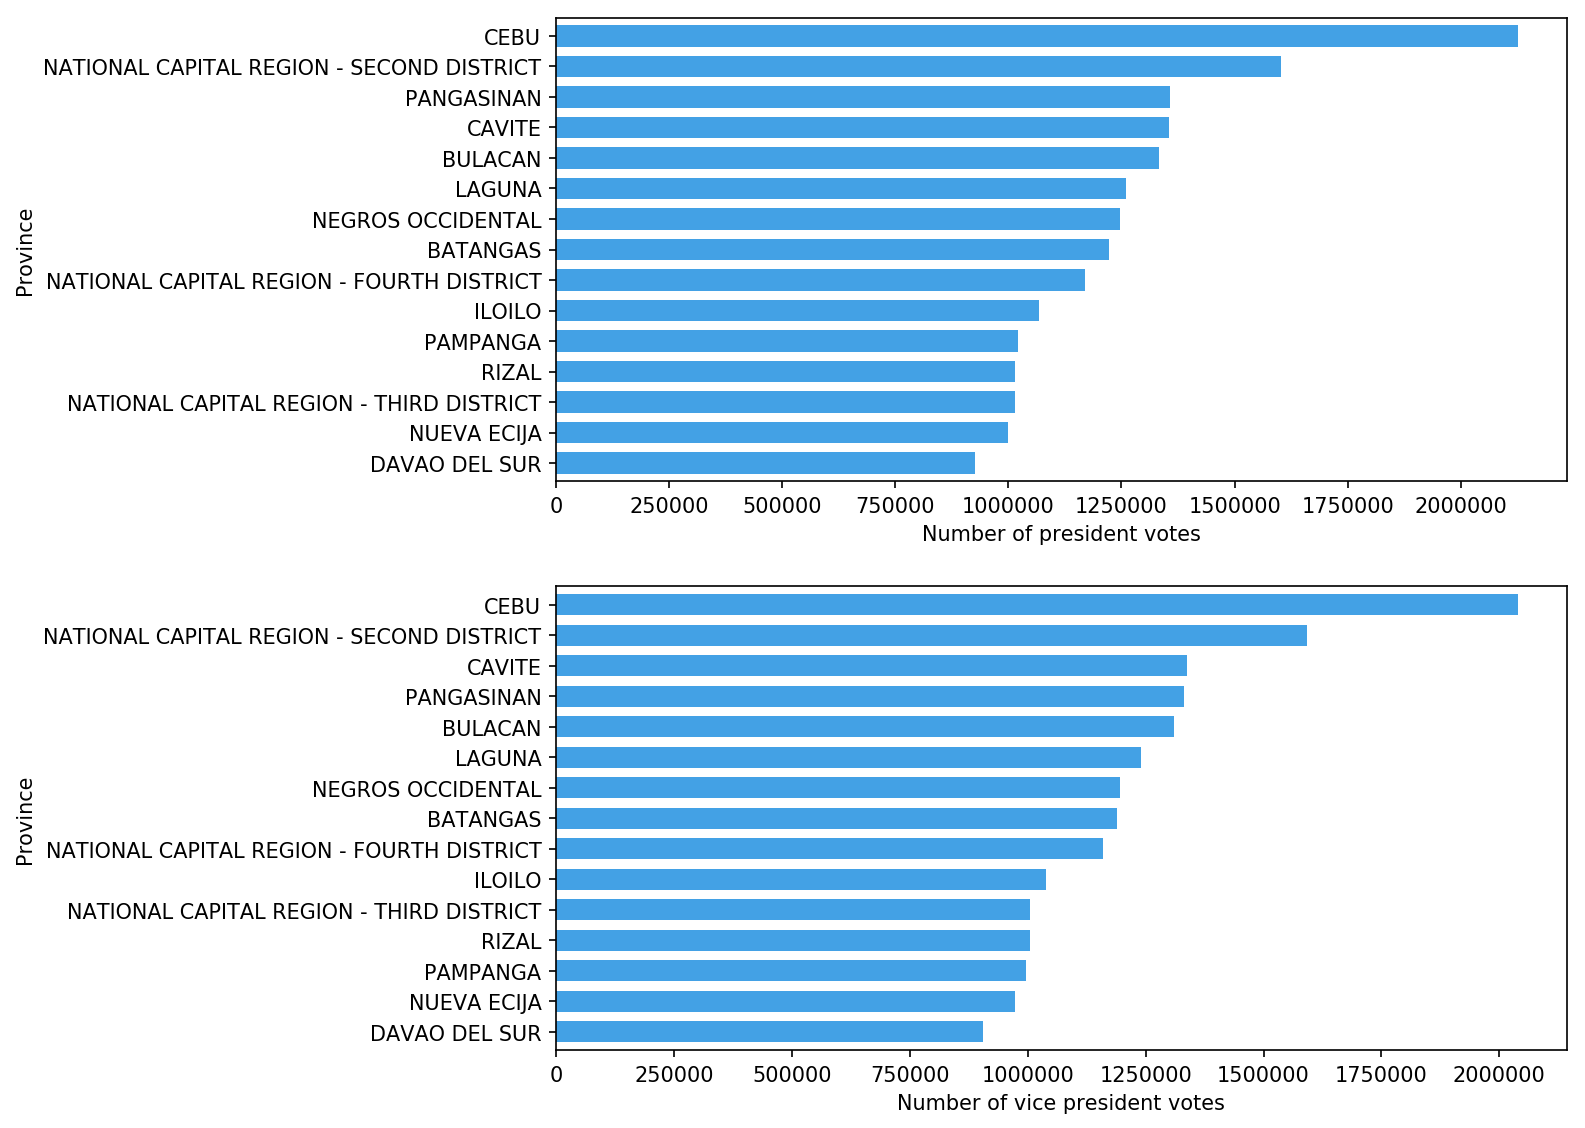

In [38]:
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(8,8))
fig.tight_layout(pad=3.0)
df_pres.groupby('province')['votes'].agg(sum).sort_values(ascending=True)[-15:].plot(kind='barh', color='#43a1e5', ax=ax[0], width=0.7)
ax[0].set_ylabel('Province')
ax[0].set_xlabel('Number of president votes')
df_vp.groupby('province')['votes'].agg(sum).sort_values(ascending=True)[-15:].plot(kind='barh', color='#43a1e5', ax=ax[1], width=0.7)
ax[1].set_ylabel('Province')
ax[1].set_xlabel('Number of vice president votes');

#### Figure 4. Total presidential and vice-presidential votes obtained per province. The most vote-rich provinces are Cebu, 2nd Distric of NCR (Mandaluyong, Marikina, Pasig, Quezon City, San Juan), Cavite, and Pangasinan

## 5. Votes Heatmap

### a. President

In [40]:
df_pres_pivot = pd.pivot_table(df_pres, index='candidate_name', columns='region', values='votes', aggfunc=sum)

In [41]:
df_pres_pivot_norm = df_pres_pivot.div(df_pres_pivot.sum(axis=0), axis=1)

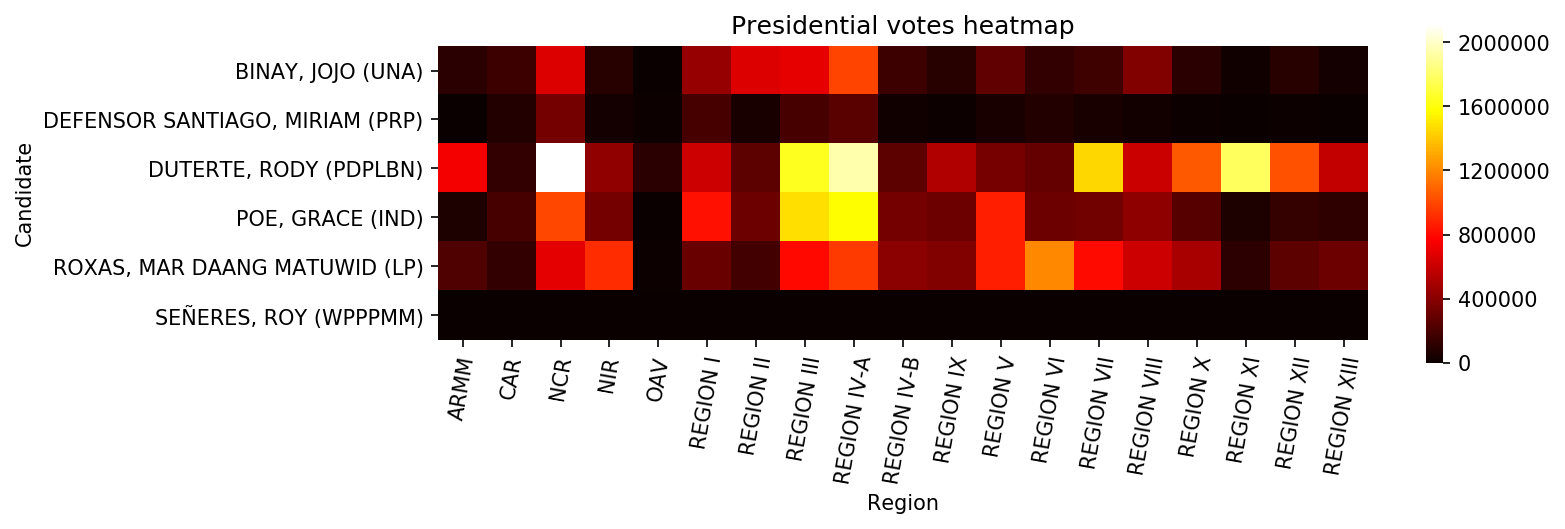

In [42]:
fig, ax = plt.subplots(dpi=150, figsize=(10,3))
sns.heatmap(df_pres_pivot, ax=ax, cmap='hot', square=True)
ax.set_xlabel('Region')
ax.set_ylabel('Candidate')
ax.set_title('Presidential votes heatmap')
plt.xticks(rotation=80);

#### Figure 5. Presidential vote heatmap, with white indicating the segment with the highest number of votes. NCR and Calabarzon contributed the most number of Duterte votes.

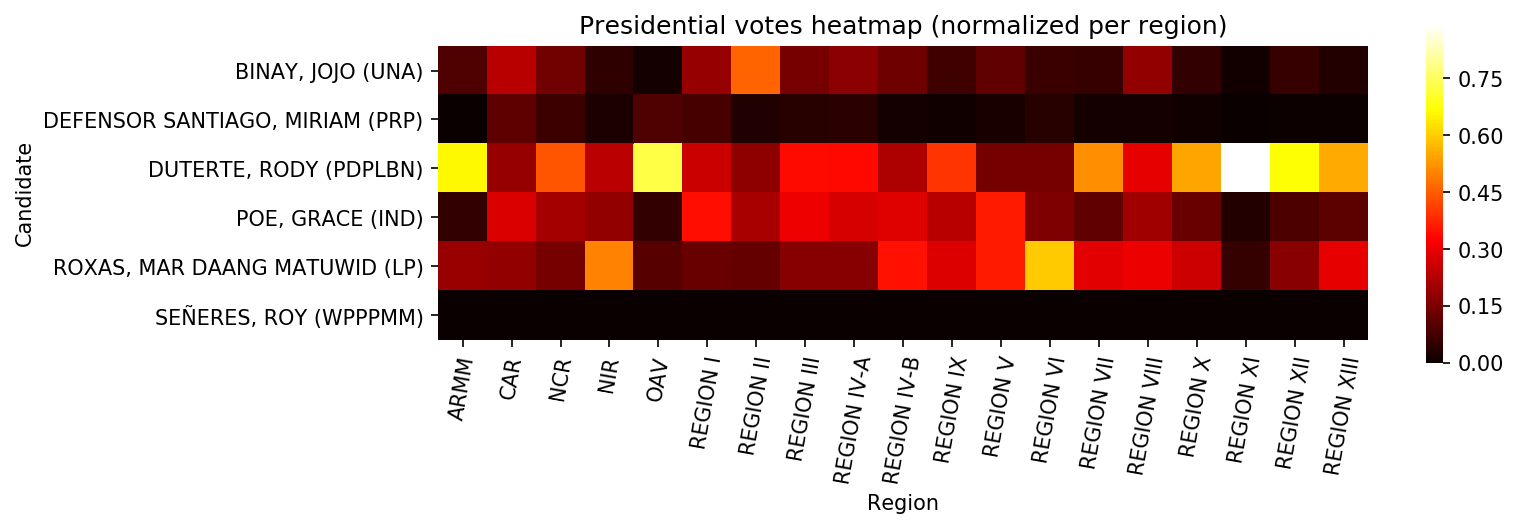

In [43]:
fig, ax = plt.subplots(dpi=150, figsize=(10,3))
sns.heatmap(df_pres_pivot_norm, ax=ax, cmap='hot', square=True)
ax.set_xlabel('Region')
ax.set_ylabel('Candidate')
ax.set_title('Presidential votes heatmap (normalized per region)')
plt.xticks(rotation=80);

#### Figure 6. Presidential vote heatmap normalized per region. 

### b. Vice President

In [45]:
df_vp_pivot = pd.pivot_table(df_vp, index='candidate_name', columns='region', values='votes', aggfunc=sum)

In [46]:
df_vp_pivot_norm = df_vp_pivot.div(df_vp_pivot.sum(axis=0), axis=1)

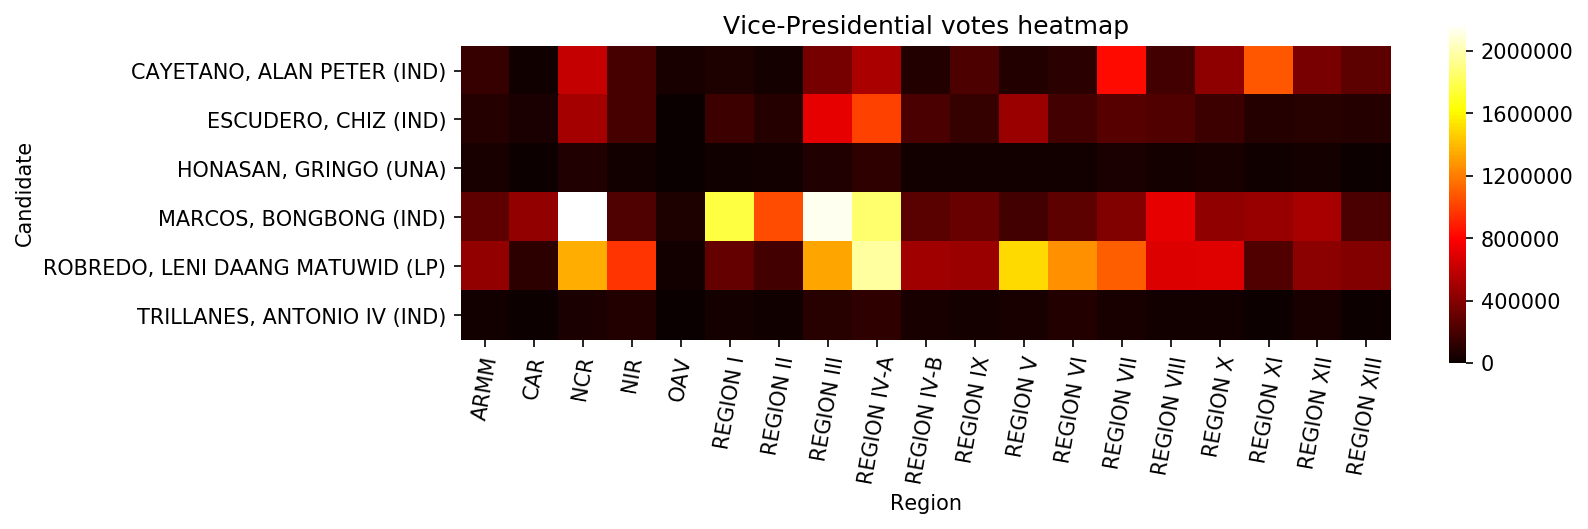

In [47]:
fig, ax = plt.subplots(dpi=150, figsize=(10,3))
sns.heatmap(df_vp_pivot, ax=ax, cmap='hot', square=True)
ax.set_xlabel('Region')
ax.set_ylabel('Candidate')
ax.set_title('Vice-Presidential votes heatmap')
plt.xticks(rotation=80);

#### Figure 7. Vice-presidential vote heatmap, with white indicating the segment with the highest number of votes. Marcos obtained a significant number of votes from NCR and Region 3, but these are not enough to surmount the aggregated votes obtained by Robredo from Region 4A, 5 and other southern regions.

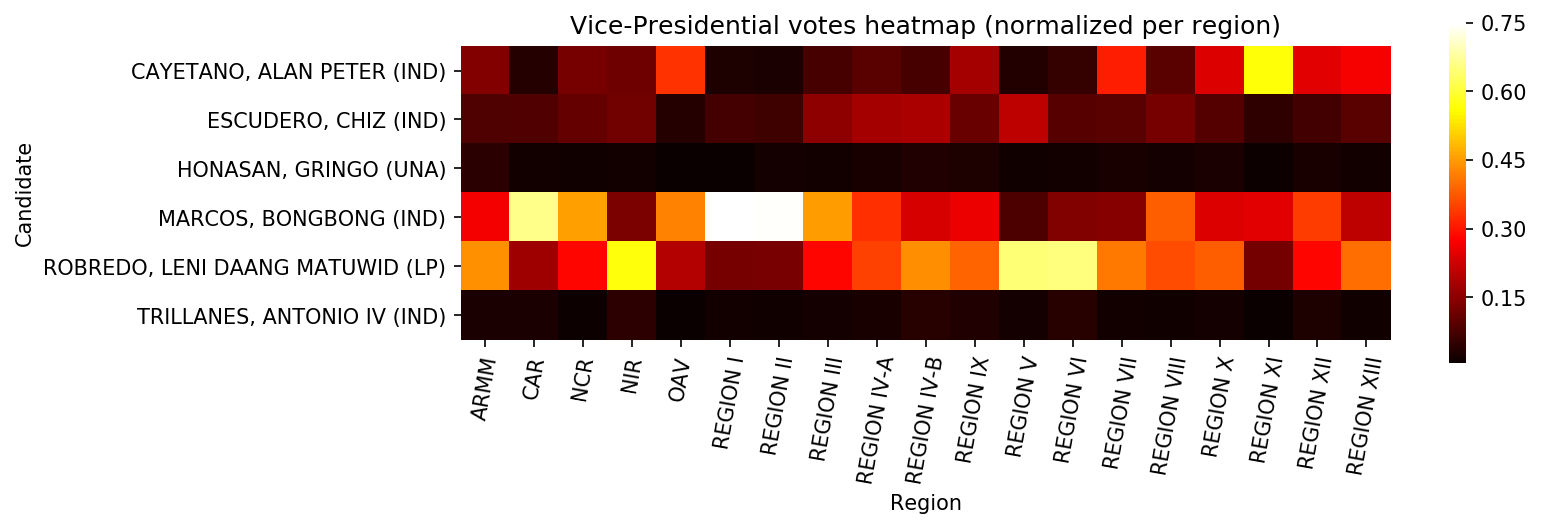

In [59]:
fig, ax = plt.subplots(dpi=150, figsize=(10,3))
sns.heatmap(df_vp_pivot_norm, ax=ax, cmap='hot', square=True)
ax.set_xlabel('Region')
ax.set_ylabel('Candidate')
ax.set_title('Vice-Presidential votes heatmap (normalized per region)')
plt.xticks(rotation=80);

Marcos obtained landslide wins in the northern Luzon regions, specifically Region 1 (Ilocos), Region 2 (Cagayan Valley), and CAR. However, this is not enough to surpass the combined votes obtained by Robredo in the southern regions, specifically in Region 5, Region 6, and NIR.  

## 6. Ranking of candidates per region

### a. Presidential Race

In [54]:
df_pres_ranking = df_pres.groupby(['region','candidate_name']).agg({'votes': sum})

In [55]:
df_pres_ranking['rank'] = df_pres_ranking.groupby('region')['votes'].rank(method='dense', ascending=False)

In [56]:
df_pres_ranking.reset_index(inplace=True)

In [57]:
df_pres_ranking_pivot = df_pres_ranking.pivot(index='candidate_name', columns='region')['rank']

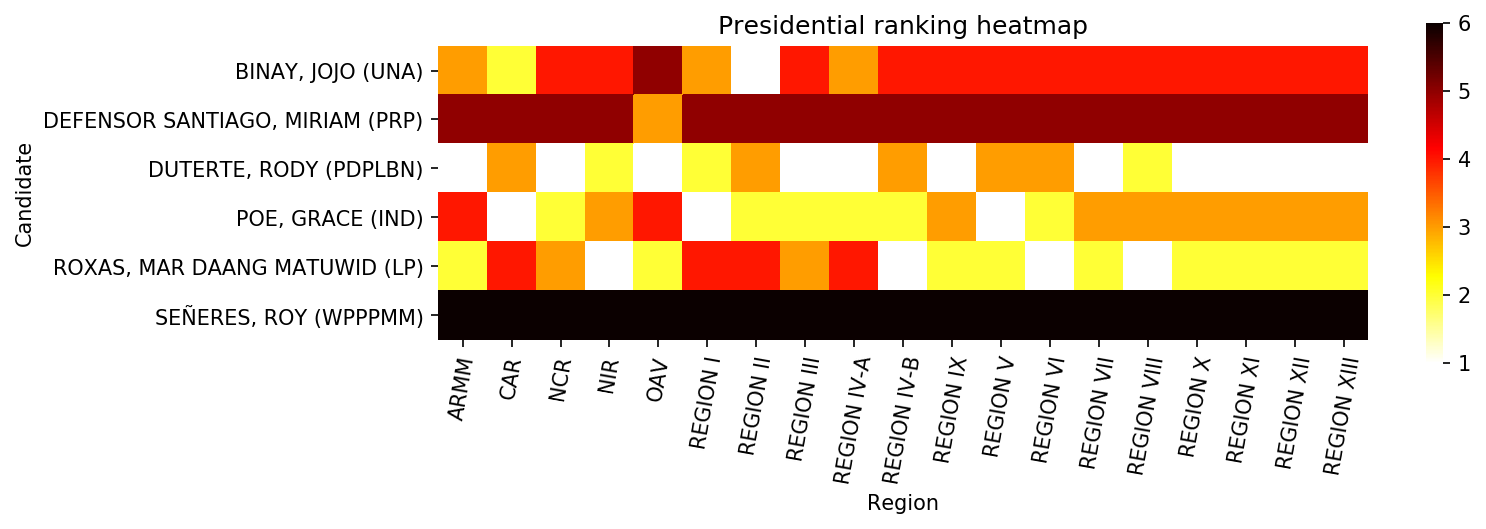

In [58]:
fig, ax = plt.subplots(dpi=150, figsize=(10,3))
sns.heatmap(df_pres_ranking_pivot, ax=ax, cmap='hot_r', square=True)
ax.set_xlabel('Region')
ax.set_ylabel('Candidate')
ax.set_title('Presidential ranking heatmap')
plt.xticks(rotation=80);

### b. Vice-Presidential Race

In [49]:
df_vp_ranking = df_vp.groupby(['region','candidate_name']).agg({'votes': sum})

In [50]:
df_vp_ranking['rank'] = df_vp_ranking.groupby('region')['votes'].rank(method='dense', ascending=False)

In [51]:
df_vp_ranking.reset_index(inplace=True)

In [52]:
df_vp_ranking_pivot = df_vp_ranking.pivot(index='candidate_name', columns='region')['rank']

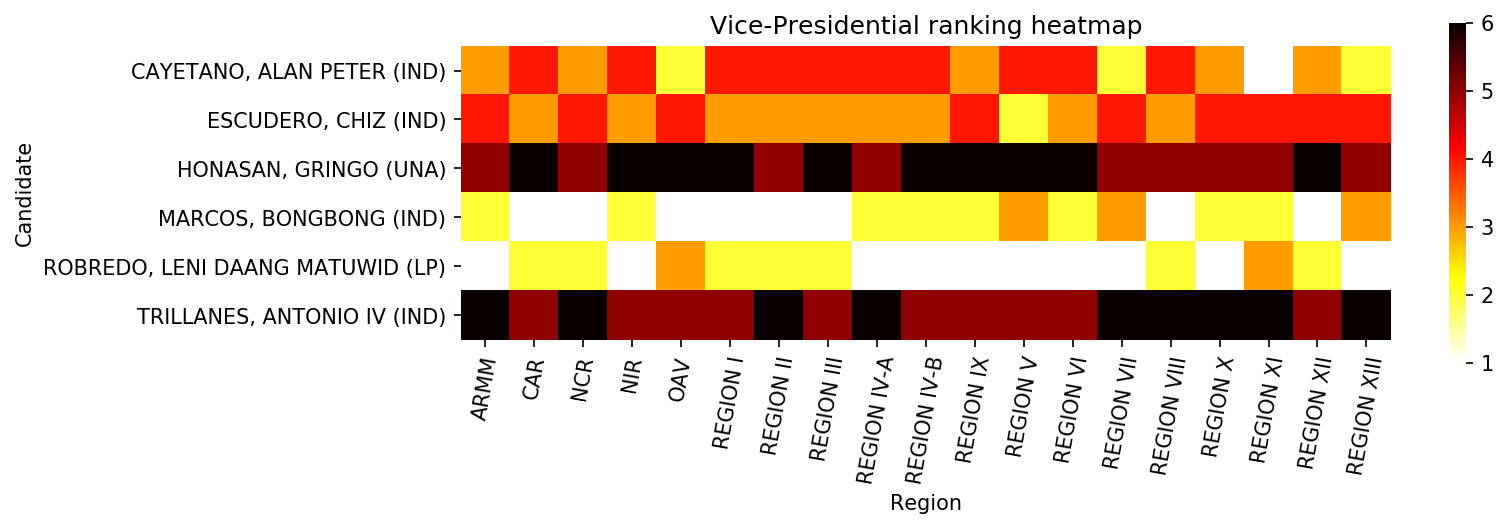

In [53]:
fig, ax = plt.subplots(dpi=150, figsize=(10,3))
sns.heatmap(df_vp_ranking_pivot, ax=ax, cmap='hot_r', square=True)
ax.set_xlabel('Region')
ax.set_ylabel('Candidate')
ax.set_title('Vice-Presidential ranking heatmap')
plt.xticks(rotation=80);

## 7. Top Candidate per Region

In [253]:
ph0 = gpd.GeoDataFrame.from_file("Datasets/ph_regions.shp")

In [254]:
ph0 = ph0.replace('BARMM', 'ARMM')

In [211]:
df_pres_top = df_pres_ranking[df_pres_ranking['rank']==1.0]

In [212]:
df_vp_top = df_vp_ranking[df_vp_ranking['rank']==1.0]

### a. President

In [213]:
pres_merged = ph0.merge(df_pres_top, left_on='region', right_on='region')

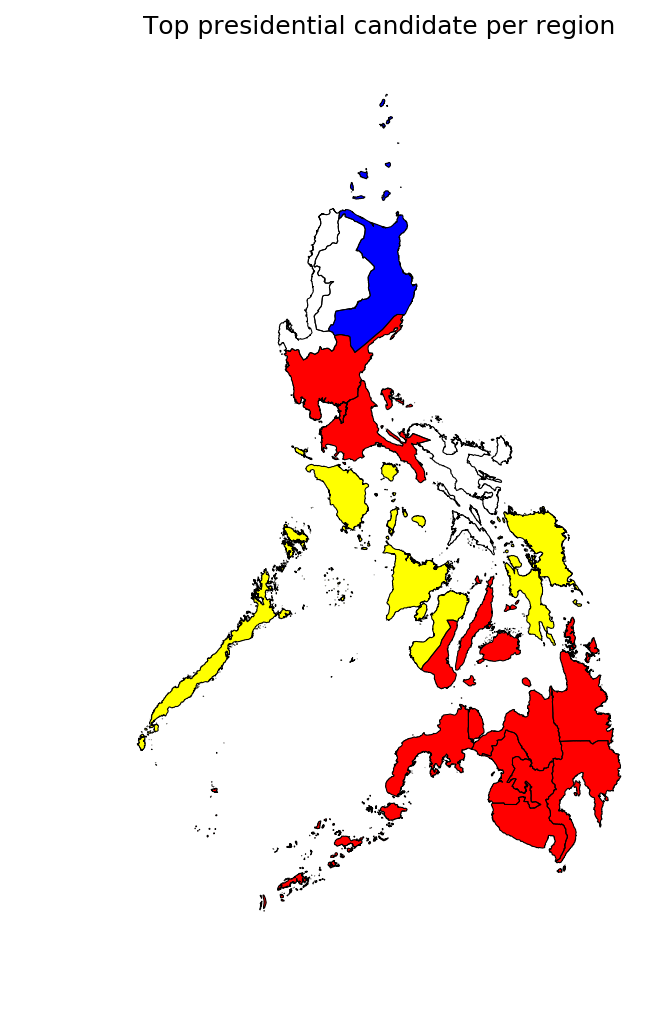

In [263]:
color_map = {'DUTERTE, RODY (PDPLBN)': 'red',
             'POE, GRACE (IND)': 'white', 
             'ROXAS, MAR DAANG MATUWID (LP)': 'yellow', 
             'BINAY, JOJO (UNA)': 'blue'}


fig, ax = plt.subplots(dpi=150, figsize=(6,8))
ax.set_title('Top presidential candidate per region', fontsize=12);

for candidate in pres_merged['candidate_name'].unique():
    pres_merged[pres_merged['candidate_name'] == candidate].plot(ax=ax, color = color_map[candidate], 
                                          categorical = True, legend=True)

pres_merged.geometry.boundary.plot(color=None,edgecolor='k',linewidth = .5,ax=ax);
plt.rcParams.update({'font.size': 18})
ax.axis('off');

### b. Vice-President

In [255]:
vp_merged = ph0.merge(df_vp_top, left_on='region', right_on='region')

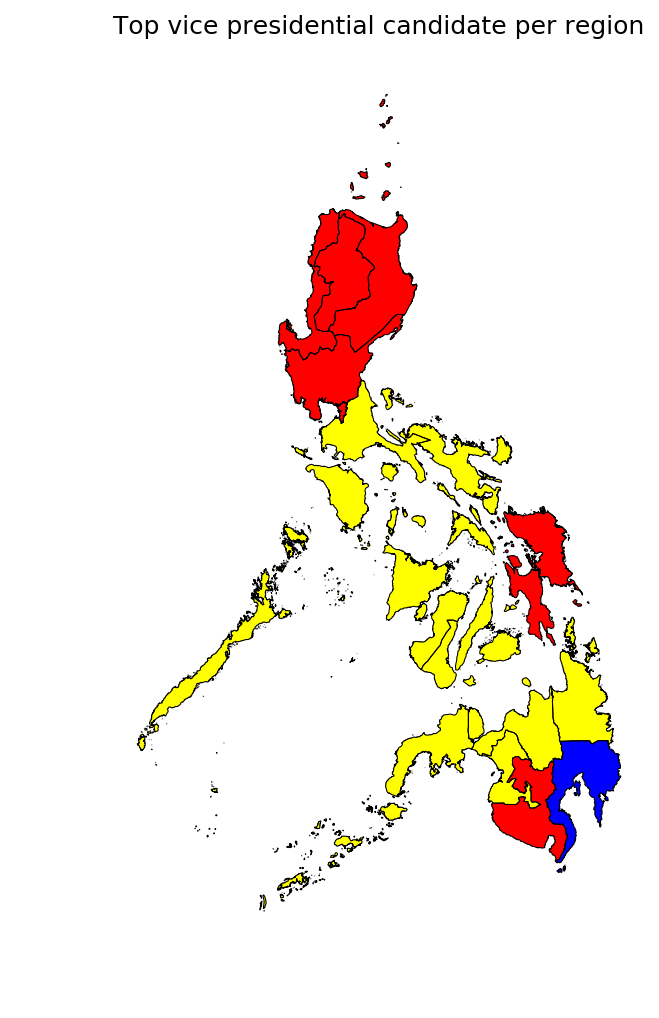

In [264]:
color_map = {'ROBREDO, LENI DAANG MATUWID (LP)': 'yellow', 
             'MARCOS, BONGBONG (IND)': 'red',
               'CAYETANO, ALAN PETER (IND)': 'blue'}


fig, ax = plt.subplots(dpi=150, figsize=(6,8))
ax.set_title('Top vice presidential candidate per region', fontsize=12);

for candidate in vp_merged['candidate_name'].unique():
    vp_merged[vp_merged['candidate_name'] == candidate].plot(ax=ax, color = color_map[candidate], 
                                          categorical = True, legend=True)

vp_merged.geometry.boundary.plot(color=None,edgecolor='k',linewidth = .5,ax=ax);
plt.rcParams.update({'font.size': 18})
ax.axis('off');